<a href="https://colab.research.google.com/github/Barikko/Yandex.Practicum-Projects/blob/main/%D0%A1%D0%B1%D0%BE%D1%80%D0%BD%D1%8B%D0%B9%20%E2%84%962.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сборный проект 2
Цель: изучить, как ведут себя пользователи мобильного приложения для продаж продуктов питания, повлияет ли на их поведение изменения шрифта в приложении.

Описание данных: файл logs_exp, в котором записаны события, id пользователя, время события и номер эксперимента (246, 247 - А/А контрольные группы, 248 - экспериментальная группа с изменённым шрифтом).

План работ:

- Предобработка данных. Определение актуальности данных. Проверка на подглядывание.
- Изучение воронки продаж. Как пользователи доходят до покупки, сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
- Исследование результатов А/А/В-эксперимента. Проверка гипотез о равенстве долей между контрольных групп, контрольных групп и экспериментальной, объединённой из контрольных и экспериментальной.

<div class="alert alert-success">

**✔️ Комментарий ревьюера ✔️**
   
   Очень хорошее введение в проект. Оно будет полезным, когда соберешь большое портфолио и в какой-то момент решишь освежить проект в памяти.

</div>


## Загрузка данных и подготовка их к анализу

In [37]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
from plotly import graph_objects as go

In [38]:
logs = pd.read_csv('/content/logs_exp.csv', sep='\t')

### Предобработка данных

In [39]:
print(logs.info())
logs['EventTimestamp'] = pd.to_datetime(logs['EventTimestamp'], unit='s')
logs.columns=['event_name','device_id_hash','event_timestamp','exp_id']
logs['event_date'] = pd.DatetimeIndex(logs['event_timestamp']).date
display(logs.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None


,event_name,device_id_hash,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [40]:
print(logs.isna().sum())
print(logs['event_name'].unique())

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
event_date         0
dtype: int64
['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


In [41]:
delet=np.intersect1d(logs.query('exp_id == 246')['device_id_hash'].unique(), logs.query('exp_id == 247')['device_id_hash'].unique())
print(delet)

delet1=np.intersect1d(logs.query('exp_id == 247')['device_id_hash'].unique(), logs.query('exp_id == 248')['device_id_hash'].unique())
print(delet1)

delet2=np.intersect1d(logs.query('exp_id == 246')['device_id_hash'].unique(), logs.query('exp_id == 248')['device_id_hash'].unique())
print(delet2)

[]
[]
[]


Столбцы переименованы, дата переведена в нужный формат, добавлен новый столбец с датой, дубликатов и пропусков нет, пользователей, принадлежащих к нескольким группам, нет.

## Изучение и проверка данных

### Сколько всего событий в логе?   

In [42]:
print('Всего событий в логе:',logs['device_id_hash'].count())

Всего событий в логе: 244126


### Сколько всего пользователей в логе?

In [43]:
users=len(logs['device_id_hash'].unique())
print('Всего пользователей в логе:',users)

Всего пользователей в логе: 7551


### Сколько в среднем событий приходится на пользователя?

In [44]:
print('Среднее количество событий на пользователя: {:.1f}'.format(logs.groupby(['device_id_hash'])['exp_id'].count().mean()))

Среднее количество событий на пользователя: 32.3


### Нахождение максимальной и минимальной даты.  Определение с какого момента данные полные.

In [45]:
print('Минимальная дата:',min(logs['event_timestamp']))
print('Максимальная дата:',max(logs['event_timestamp']))

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17


На первый взгляд мы располагаем данными за две недели - с 25.07.2019 до 07.08.2019

### Гистограмма по дате и времени. 

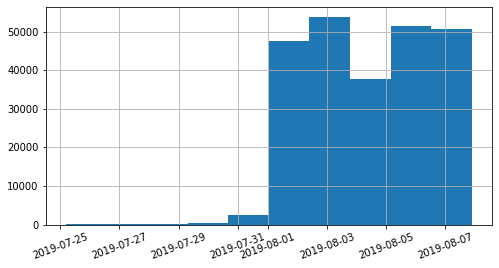

<Figure size 720x360 with 0 Axes>

In [46]:
plt.figure(figsize=(8,4))
logs['event_timestamp'].hist()
plt.xticks(rotation = 20)
plt.figure(figsize=(10,5));

Данные полны с 08.01.2019. Более ранние данные отброшены. Мы располагаем данными за одну неделю - с 01.08.2019 до 07.08.2019.

In [47]:
#Отбрасываем более старые данные
logs_old=logs.query('event_timestamp<"2019-08-01 00:00:00"')
logs1=logs.query('event_timestamp>"2019-08-01 00:00:00"')

###  Много ли событий и пользователей потеряно?

In [48]:
print('Всего отброшено пользователей:',len(logs_old['device_id_hash'].unique()),', что является {:.1f}%'.format(\
      len(logs_old['device_id_hash'].unique())/len(logs['device_id_hash'].unique())*100),' от общего числа')
print('Всего отброшено событий:',logs_old['device_id_hash'].count(),', что является {:.1f}%'.format(\
      logs_old['device_id_hash'].count()/logs['device_id_hash'].count()*100),' от общего числа')

Всего отброшено пользователей: 1451 , что является 19.2%  от общего числа
Всего отброшено событий: 2828 , что является 1.2%  от общего числа


### Есть ли пользователи из всех трёх экспериментальных групп?

In [49]:
print(logs1.groupby('exp_id')['device_id_hash'].nunique())

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64


В каждой группе есть пользователи.

## Воронка событий

###  Какие события есть в логах, как часто они встречаются?

In [50]:
print(logs1.groupby('event_name')['device_id_hash'].count().sort_values(ascending = False))

event_name
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: device_id_hash, dtype: int64


В логах есть такие события как:
1. Главный экран
2. Экран с предложениями
3. Экран покупки
4. Экран успешной оплаты
5. Экран обучения

Самое популярное событие - открытие главного экрана, наименее популярное - прохождение туториала

### Сколько пользователей совершали каждое из этих событий?

In [51]:
print(
    logs1.pivot_table(index = 'event_name',values='device_id_hash', aggfunc='nunique')\
    .sort_values(by='device_id_hash',ascending = False)
    )

main = logs1.query('event_name=="MainScreenAppear"')['device_id_hash'].nunique()
offer = logs1.query('event_name=="OffersScreenAppear"')['device_id_hash'].nunique()
cart = logs1.query('event_name=="CartScreenAppear"')['device_id_hash'].nunique()
pay = logs1.query('event_name=="PaymentScreenSuccessful"')['device_id_hash'].nunique()
tut = logs1.query('event_name=="Tutorial"')['device_id_hash'].nunique()
print('')
print('Доля пользователей, которые хоть раз совершали событие: {:.1f}%'.format(main/users*100))

                         device_id_hash
event_name                             
MainScreenAppear                   7419
OffersScreenAppear                 4593
CartScreenAppear                   3734
PaymentScreenSuccessful            3539
Tutorial                            840

Доля пользователей, которые хоть раз совершали событие: 98.3%


### В каком порядке происходят события?

События происходят в порядке с наиболее частого до наименее, кроме обучения (Tutorial), которое не относится к воронке, а является необязательным действием в приложении.

Установка приложения => MainScreenAppear => OffersScreenAppear => CartScreenAppear => PaymentScreenSuccessful

In [52]:
fig = go.Figure(go.Funnel(
    y = ["Главный экран", "Экран с предложениями", "Экран покупки", "Экран успешной оплаты"],
    x = [main, offer, cart, pay]))

fig.show()

### Подсчёт по воронке событий, какая доля пользователей проходит на следующий шаг воронки

In [53]:
print('Доля пользователей, открывших приложеник: {:.1f}%'.format(main/users*100))
print('Доля пользователей, открывших экран предложений: {:.1f}%'.format(offer/main*100))
print('Доля пользователей, открывших CartScreenAppear: {:.1f}%'.format(cart/offer*100))
print('Доля пользователей, открывших PaymentScreenSuccessful: {:.1f}%'.format(pay/cart*100))

Доля пользователей, открывших приложеник: 98.3%
Доля пользователей, открывших экран предложений: 61.9%
Доля пользователей, открывших CartScreenAppear: 81.3%
Доля пользователей, открывших PaymentScreenSuccessful: 94.8%


### На каком шаге теряется больше всего пользователей?

На шаге с открытием экрана предложений (OffersScreenAppear) потеряно больше всего пользователей (37% или 2826 пользователей)

### Какая доля пользователей доходит от первого события до оплаты?

In [54]:
print('Доля пользователей, дошедших от первого события до оплаты: {:.1f}%'.format(pay/main*100))

Доля пользователей, дошедших от первого события до оплаты: 47.7%


## Изучение результатов эксперимента  

###  Сколько пользователей в каждой экспериментальной группе?

In [55]:
countgr = logs1.groupby('exp_id')['device_id_hash'].nunique()
print(countgr)

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64


### Находят ли статистические критерии разницу между выборками 246 и 247?

H0 - статистически значимых различий между группами 246 и 247 (и всеми событиями в воронке) нет;

H - статистически значимые различия между группами 246 и 247 (и всеми событиями) есть

#### Воронка группы 246

In [56]:
logs246=logs1.query('exp_id==246').groupby('event_name')['device_id_hash'].nunique().sort_values(ascending = False)
print('Воронка группы 246')
print(logs246)

Воронка группы 246
event_name
MainScreenAppear           2450
OffersScreenAppear         1542
CartScreenAppear           1266
PaymentScreenSuccessful    1200
Tutorial                    278
Name: device_id_hash, dtype: int64


#### Воронка группы 247

In [57]:
logs247=logs1.query('exp_id==247').groupby('event_name')['device_id_hash'].nunique().sort_values(ascending = False)
print('Воронка группы 247')
print(logs247)

Воронка группы 247
event_name
MainScreenAppear           2476
OffersScreenAppear         1520
CartScreenAppear           1238
PaymentScreenSuccessful    1158
Tutorial                    283
Name: device_id_hash, dtype: int64


#### Воронка группы 248

In [58]:
logs248=logs1.query('exp_id==248').groupby('event_name')['device_id_hash'].nunique().sort_values(ascending = False)
print('Воронка группы 248')
print(logs248)

Воронка группы 248
event_name
MainScreenAppear           2493
OffersScreenAppear         1531
CartScreenAppear           1230
PaymentScreenSuccessful    1181
Tutorial                    279
Name: device_id_hash, dtype: int64


In [59]:
print("Cамое популярное событие - MainScreenAppear, открытие основного экрана.\n"
      'Число пользователей, совершивших это событие в каждой из контрольных групп -',logs246[0],'и',logs247[0],'.\n'
      'Доля пользователей, совершивших это событие - {:.1f}%'.format(logs246[0]/countgr[247]*100),'и {:.1f}%'.format(logs247[0]/countgr[247]*100))

Cамое популярное событие - MainScreenAppear, открытие основного экрана.
Число пользователей, совершивших это событие в каждой из контрольных групп - 2450 и 2476 .
Доля пользователей, совершивших это событие - 97.5% и 98.5%


In [60]:
#функия для проверки гипотез
def check_event_hypothesis(count_1, count_2, nobs_1, nobs_2, alpha = 0.05):
    count = np.array([count_1, count_2]) 
    nobs = np.array([nobs_1, nobs_2]) 
    stat, pval = proportions_ztest(count, nobs) 
    return pval

alpha = 0.05

In [61]:
print('p-value: {:.3f}'.format(check_event_hypothesis(logs246[0], logs247[0], countgr[246], countgr[247], alpha = 0.05)))

if check_event_hypothesis(logs246[0], logs247[0], countgr[246], countgr[247], alpha = 0.05) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу\n'
        'Статистически значимых различий между группами 246 и 247 на шаге Все пользователи => Главный экран нет'
    ) 
print('') 
print('p-value: {:.3f}'.format(check_event_hypothesis(logs246[1], logs247[1], countgr[246], countgr[247], alpha = 0.05)))

if check_event_hypothesis(logs246[1], logs247[1], countgr[246], countgr[247], alpha = 0.05) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу\n'
        'Статистически значимых различий между группами 246 и 247 на шаге Главный экран => Экран предложений нет'
    )
print('')    
print('p-value: {:.3f}'.format(check_event_hypothesis(logs246[2], logs247[2], countgr[246], countgr[247], alpha = 0.05)))

if check_event_hypothesis(logs246[2], logs247[2], countgr[246], countgr[247], alpha = 0.05) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу\n'
        'Статистически значимых различий между группами 246 и 247 на шаге Экран предложений => Экран покупки нет'
    )
print('')
print('p-value: {:.3f}'.format(check_event_hypothesis(logs246[3], logs247[3], countgr[246], countgr[247], alpha = 0.05)))

if check_event_hypothesis(logs246[3], logs247[3], countgr[246], countgr[247], alpha = 0.05) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу\n'
        'Статистически значимых различий между группами 246 и 247 на шаге Экран покупки => Экран успешной оплаты нет'
    )

p-value: 0.757
Не получилось отвергнуть нулевую гипотезу
Статистически значимых различий между группами 246 и 247 на шаге Все пользователи => Главный экран нет

p-value: 0.248
Не получилось отвергнуть нулевую гипотезу
Статистически значимых различий между группами 246 и 247 на шаге Главный экран => Экран предложений нет

p-value: 0.229
Не получилось отвергнуть нулевую гипотезу
Статистически значимых различий между группами 246 и 247 на шаге Экран предложений => Экран покупки нет

p-value: 0.115
Не получилось отвергнуть нулевую гипотезу
Статистически значимых различий между группами 246 и 247 на шаге Экран покупки => Экран успешной оплаты нет


###  Можно ли сказать, что разбиение на группы работает корректно?

Да, разбиение на группы работает корректно, нулевая гипотеза не отвергнута.

###  Сравнение результатов с каждой из контрольных групп в отдельности по каждому событию.

#### Сравнение группы 246 и 248:

H0 - статистически значимых различий между группами 246 и 248 (и всеми событиями в воронке) нет;

H - статистически значимые различия между группами 246 и 248 (и всеми событиями) есть


In [62]:
print('p-value: {:.3f}'.format(check_event_hypothesis(logs246[0], logs248[0], countgr[246], countgr[248], alpha = 0.05)))

if check_event_hypothesis(logs246[0], logs248[0], countgr[246], countgr[248], alpha = 0.05) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу\n'
        'Статистически значимых различий между группами 246 и 248 на шаге Все пользователи => Главный экран нет'
    )
print('')    
print('p-value: {:.3f}'.format(check_event_hypothesis(logs246[1], logs248[1], countgr[246], countgr[248], alpha = 0.05)))

if check_event_hypothesis(logs246[1], logs248[1], countgr[246], countgr[248], alpha = 0.05) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу\n'
        'Статистически значимых различий между группами 246 и 248 на шаге Главный экран => Экран предложений нет'
    )
print('')    
print('p-value: {:.3f}'.format(check_event_hypothesis(logs246[2], logs248[2], countgr[246], countgr[248], alpha = 0.05)))

if check_event_hypothesis(logs246[2], logs248[2], countgr[246], countgr[248], alpha = 0.05) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу\n'
        'Статистически значимых различий между группами 246 и 248 на шаге Экран предложений => Экран покупки нет'
    )
print('')
print('p-value: {:.3f}'.format(check_event_hypothesis(logs246[3], logs248[3], countgr[246], countgr[248], alpha = 0.05)))

if check_event_hypothesis(logs246[3], logs248[3], countgr[246], countgr[248], alpha = 0.05) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу\n'
        'Статистически значимых различий между группами 246 и 248 на шаге Экран покупки => Экран успешной оплаты нет'
    )

p-value: 0.295
Не получилось отвергнуть нулевую гипотезу
Статистически значимых различий между группами 246 и 248 на шаге Все пользователи => Главный экран нет

p-value: 0.208
Не получилось отвергнуть нулевую гипотезу
Статистически значимых различий между группами 246 и 248 на шаге Главный экран => Экран предложений нет

p-value: 0.078
Не получилось отвергнуть нулевую гипотезу
Статистически значимых различий между группами 246 и 248 на шаге Экран предложений => Экран покупки нет

p-value: 0.212
Не получилось отвергнуть нулевую гипотезу
Статистически значимых различий между группами 246 и 248 на шаге Экран покупки => Экран успешной оплаты нет


#### Сравнение группы 247 и 248

H0 - статистически значимых различий между группами 247 и 248 (и всеми событиями в воронке) нет;

H - статистически значимые различия между группами 247 и 248 (и всеми событиями) есть


In [63]:
print('p-value: {:.3f}'.format(check_event_hypothesis(logs247[0], logs248[0], countgr[247], countgr[248], alpha = 0.05)))

if check_event_hypothesis(logs247[0], logs248[0], countgr[247], countgr[248], alpha = 0.05) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу\n'
        'Статистически значимых различий между группами 247 и 248 на шаге Все пользователи => Главный экран нет'
    )
print('')    
print('p-value: {:.3f}'.format(check_event_hypothesis(logs247[1], logs248[1], countgr[247], countgr[248], alpha = 0.05)))

if check_event_hypothesis(logs247[1], logs248[1], countgr[247], countgr[248], alpha = 0.05) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу\n'
        'Статистически значимых различий между группами 247 и 248 на шаге Главный экран => Экран предложений нет'
    )
print('')   
print('p-value: {:.3f}'.format(check_event_hypothesis(logs247[2], logs248[2], countgr[247], countgr[248], alpha = 0.05)))

if check_event_hypothesis(logs247[2], logs248[2], countgr[247], countgr[248], alpha = 0.05) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу\n'
        'Статистически значимых различий между группами 247 и 248 на шаге Экран предложений => Экран покупки нет'
    )
print('')    
print('p-value: {:.3f}'.format(check_event_hypothesis(logs247[3], logs248[3], countgr[247], countgr[248], alpha = 0.05)))

if check_event_hypothesis(logs247[3], logs248[3], countgr[247], countgr[248], alpha = 0.05) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу\n'
        'Статистически значимых различий между группами 247 и 248 на шаге Экран покупки => Экран успешной оплаты нет'
    )

p-value: 0.459
Не получилось отвергнуть нулевую гипотезу
Статистически значимых различий между группами 247 и 248 на шаге Все пользователи => Главный экран нет

p-value: 0.920
Не получилось отвергнуть нулевую гипотезу
Статистически значимых различий между группами 247 и 248 на шаге Главный экран => Экран предложений нет

p-value: 0.579
Не получилось отвергнуть нулевую гипотезу
Статистически значимых различий между группами 247 и 248 на шаге Экран предложений => Экран покупки нет

p-value: 0.737
Не получилось отвергнуть нулевую гипотезу
Статистически значимых различий между группами 247 и 248 на шаге Экран покупки => Экран успешной оплаты нет


 ### Сравнение результатов с объединённой контрольной группой.

In [64]:
#объединим группы
logs_uni=logs246+logs247
print(logs_uni)

event_name
MainScreenAppear           4926
OffersScreenAppear         3062
CartScreenAppear           2504
PaymentScreenSuccessful    2358
Tutorial                    561
Name: device_id_hash, dtype: int64


#### Сравнение объединённой группы с 248

In [65]:
print('p-value: {:.3f}'.format(check_event_hypothesis(logs_uni[0], logs248[0], countgr[246]+countgr[247], countgr[248], alpha = 0.05)))

if check_event_hypothesis(logs_uni[0], logs248[0], countgr[246]+countgr[247], countgr[248], alpha = 0.05) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу\n'
        'Статистически значимых различий между объединённой группой и 248 на шаге Все пользователи => Главный экран нет'
    )
print('')    
print('p-value: {:.3f}'.format(check_event_hypothesis(logs_uni[1], logs248[1], countgr[246]+countgr[247], countgr[248], alpha = 0.05)))

if check_event_hypothesis(logs_uni[1], logs248[1], countgr[246]+countgr[247], countgr[248], alpha = 0.05) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу\n'
        'Статистически значимых различий между объединённой группой и 248 на шаге Главный экран => Экран предложений нет'
    )
print('')   
print('p-value: {:.3f}'.format(check_event_hypothesis(logs_uni[2], logs248[2], countgr[246]+countgr[247], countgr[248], alpha = 0.05)))

if check_event_hypothesis(logs_uni[2], logs248[2], countgr[246]+countgr[247], countgr[248], alpha = 0.05) < alpha:
    print('Отвергаем нулевую гипотезу, статистически значимые различия между объединённой группой и 248 на шаге Экран предложений => Экран покупки есть')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу\n'
        'Статистически значимых различий между объединённой группой и 248 на шаге Экран предложений => Экран покупки нет'
    )
print('')    
print('p-value: {:.3f}'.format(check_event_hypothesis(logs_uni[3], logs248[3], countgr[246]+countgr[247], countgr[248], alpha = 0.05)))

if check_event_hypothesis(logs_uni[3], logs248[3], countgr[246]+countgr[247], countgr[248], alpha = 0.05) < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу\n'
        'Статистически значимых различий между объединённой группой и 248 на шаге Экран покупки => Экран успешной оплаты нет'
    )

p-value: 0.294
Не получилось отвергнуть нулевую гипотезу
Статистически значимых различий между объединённой группой и 248 на шаге Все пользователи => Главный экран нет

p-value: 0.434
Не получилось отвергнуть нулевую гипотезу
Статистически значимых различий между объединённой группой и 248 на шаге Главный экран => Экран предложений нет

p-value: 0.182
Не получилось отвергнуть нулевую гипотезу
Статистически значимых различий между объединённой группой и 248 на шаге Экран предложений => Экран покупки нет

p-value: 0.600
Не получилось отвергнуть нулевую гипотезу
Статистически значимых различий между объединённой группой и 248 на шаге Экран покупки => Экран успешной оплаты нет


### Какие выводы из эксперимента можно сделать?

После предобработки данных и анализа временного отрезка длиной в неделю были сделаны следующие наблюдения и выводы:

- Воронка событий выглядит так: Установка приложения => MainScreenAppear => OffersScreenAppear => CartScreenAppear => PaymentScreenSuccessful
- Событие Tutorial не относится к воронке, является необязательным и не было использовано в тестах
- На шаге с открытием экрана предложений (OffersScreenAppear) потеряно больше всего пользователей (37% или 2826 пользователей)
- Доля пользователей, дошедших от первого события до оплаты: 47.7%
- При сравнении групп 246 и 247 были составлены данные гипотезы:
    - H0 - статистически значимых различий между группами 246 и 247 (и всеми событиями в воронке) нет;
    
    - H - статистически значимые различия между группами 246 и 247 (и всеми событиями) есть
    
    Во всех тестах p-value было больше заданного значения альфа (0.05), нулевая гипотеза не отвергнута, что говорит о том, что разбиение на группы работает корректно, нулевая гипотеза не отвергнута.
- Далее такие же гипотезы были составлены при последующих тестах, сравнивающих события группы 246 и 248, 247 и 248, объединённых 246+247 и 248. Во всех 16 тестах нулевая гипотеза не отвергнута. Такие результаты тестов говорят о том, что статистической разницы между группами нет и изменение шрифта никак не повлияло на пользовательский опыт.

Принимая во внимание наличие множественных проверок статистических гипотез, можно скорректировать уровень альфа. Поравка Бонферрони в данном проекте не подойдёт, так как тестов 16 и при использовании данной поправки уровень альфа уменьшится до 0.05/16=0.003

### Какой уровень значимости был выбран при проверке статистических гипотез выше?

Уровень значимости был выбран 0.05, количество проверок гипотез - 16.